# Proyecto de graduación - Telecom

## Descripción 
El operador de telecomunicaciones "Nizugorazyva com" quiere aprender a predecir la salida de clientes. Si resulta que el usuario está planeando irse, se ofrecerán códigos promocionales y condiciones especiales. El equipo del operador recopiló datos personales sobre algunos clientes, información sobre sus tarifas y contratos.

#### Descripción de los servicios

El operador ofrece dos tipos principales de servicios:
1. Comunicación telefónica fija. Es posible conectar el teléfono a varias líneas simultáneamente.
2. Internet. La conexión puede ser de dos tipos: línea telefónica (DSL*,* del Ing. *línea de abonado digital*, "línea de abonado digital") o cable de fibra óptica (*fibra óptica*).  

Los siguientes servicios también están disponibles:

- seguridad en Internet: antivirus (*DeviceProtection*) y bloqueo de sitios inseguros (*OnlineSecurity*);
- línea de asistencia técnica especializada (*TechSupport*);
- almacenamiento en la nube para copias de seguridad de datos (*OnlineBackup*);
- Streaming de televisión (*StreamingTV*) y catálogo de películas (*StreamingMovies*).

Los clientes pueden pagar por los servicios cada mes o celebrar un contrato por 1-2 años. Existen varios métodos de cálculo y la posibilidad de obtener un control electrónico.

### Puntos de dolor del cliente

El cliente ha refinado sus métricas de negocio y dolores. Estas son pérdidas debidas a promociones ineficientes con promociones, descuentos y otros incentivos. Las empresas de marketing identifican dos puntos de presión:
1) al usuario se le ofrecieron códigos promocionales, pero no se iba a ir (ejemplo clásico de Falso Positivo en nuestro idioma);  
2) Al usuario no se le ofreció nada y se fue (como dicen, Falso Negativo).  
Además de ROC-AUC, el cliente quiere una métrica interpretable para que la administración pueda entender el informe. Es por eso que utilizamos ROC-AUC para nosotros (F-medida además), y para el cliente en la muestra de prueba que necesita para ver la matriz de precisión y error para un informe convincente más tarde.

### Data

[contract_new.csv](https://code.s3.yandex.net/datasets/contract_new.csv)  
[personal_new.csv](https://code.s3.yandex.net/datasets/personal_new.csv)  
[internet_new.csv](https://code.s3.yandex.net/datasets/internet_new.csv)  
[phone_new.csv](https://code.s3.yandex.net/datasets/phone_new.csv)  

### Descripción de los datos

Los datos consisten en archivos de diferentes fuentes:

- contrato nuevo - información sobre el contrato;
- [personal_new.csv€. - datos personales del cliente;
- información sobre los servicios de Internet;
- Información sobre los servicios de telefonía.

En todos los archivos, la columna ːcustomerID! contiene el código del cliente.

La información sobre los tratados es actual el 1 de febrero de 2020.

El cliente ya ha proporcionado los datos y su descripción. Aquí hay algunos detalles de la carta de presentación:
- personal_new.csv - datos personales del cliente
    - género
    - SeniorCitizen - estado de la pensión de vejez
    - Pareja - Presencia del cónyuge
    - Dependientes - Disponibilidad de Dependientes
- contract_new.csv - información del contrato
    - BeginDate - fecha de inicio del servicio
    - EndDate - fecha de finalización del servicio
    - Tipo - tipo de contrato: mensual, anual, etc
    - PaperlessBilling - Facturación por correo electrónico
    - PaymentMethod - método de pago
    - MonthlyCharges - gastos mensuales por servicios
    - TotalCharges - todo el dinero gastado en servicios
- internet_new.csv - información sobre los servicios de Internet
    - InternetService - disponibilidad de servicios de Internet
    - OnlineSecurity - Cortafuegos
    - OnlineBackup - Almacenamiento en la nube para la copia de seguridad de datos
    - DeviceProtection - antivirus
    - TechSupport - línea de asistencia técnica especializada
    - StreamingTV - televisión en línea
- StreamingMovies - cine en línea
- phone_new.csv - información sobre los servicios de telefonía
    - MultipleLines - la posibilidad de conectar un teléfono a varias líneas al mismo tiempo

## Descarga y visualización de los datos

In [1]:
from catboost import CatBoostClassifier, Pool
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
# Combinar tablas en una sola
# Antes de agregar valores a las tablas de Internet y Teléfono para evitar perder datos, quién usó qué servicio

internet['Internet'] = 'Yes'
phone['Phone'] = 'Yes'

In [8]:
# Ahora fusionemos las tablas en un dato por el customerID de la columna

data = contract
data = pd.concat([data.set_index('customerID'), personal.set_index('customerID')], axis=1)
data = pd.concat([data, internet.set_index('customerID')], axis=1)
data = pd.concat([data, phone.set_index('customerID')], axis=1)

In [10]:
data.head(5).T

customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
BeginDate,2020-01-01,2017-04-01,2019-10-01,2016-05-01,2019-09-01
EndDate,No,No,No,No,No
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
TotalCharges,31.04,2071.84,226.17,1960.6,353.5
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

### Cambiar los tipos de datos y rellenar las omisiones

In [12]:
# Cambiar los tipos de datos y llenar los vacíos cuando sea necesario:

data['BeginDate'] = pd.to_datetime(data['BeginDate']) # start date of the contract simply type

In [13]:
# La columna del pensionista se convertirá al formato Sí/No similar a otras columnas

data['SeniorCitizen'] = data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

In [14]:
# También iremos con las columnas creadas anteriormente Internet y Teléfono. Sí, ya hemos especificado, y todos los pases serán reemplazados por No.

data['Internet'] = data['Internet'].fillna('No')
data['Phone'] = data['Phone'].fillna('No')

In [15]:
# Al intentar convertir una columna de TotalCharges a un tipo numérico, se produjo un error que no todos los valores son números. 
# Al analizar, se encontró que el error es aplicable a los 11 valores que firmaron este mes, 
# y probablemente todavía no han tenido tiempo de pagar por los servicios. Vamos a reemplazar sus valores con 0 y cambiar el tipo de datos.
data['TotalCharges'] = data['TotalCharges'].str.strip().replace('', float('nan')).fillna('0').astype(float)

In [16]:
# Queda por convertir la columna EndDate al tipo de fecha, pero podemos ver incluso desde los primeros cinco registros que también contiene un valor
# No, i.e. el usuario continúa usando los servicios. Primero cree la columna de destino, y establezca el valor a 1 allí,
# donde hay una fecha final para el contrato.

data['Gone'] = (data['EndDate'] != 'No').astype(bool)

In [17]:
# Ahora podemos cambiar el tipo de datos, pero los espacios en blanco se llenarán con la fecha de hoy

data['EndDate'] = data['EndDate'].where(data['EndDate'] != 'No', '2020-02-01')
data['EndDate'] = pd.to_datetime(data['EndDate'])

In [18]:
# Asegúrese de que los tipos de datos son correctos en todas partes.

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

In [19]:
# Vemos que las omisiones están solo en las columnas relacionadas con los servicios telefónicos o de Internet. Considerando que
# Tablas cliente combinadas de ambas direcciones, es lógico que el servicio de Internet omita los clientes de telefonía
# y viceversa. Rellenemos las omisiones con los valores No, porque estos servicios no son utilizados exactamente por los clientes

data = data.fillna('No')

### Examen de la distribución de temas

In [20]:
# Mira cómo se distribuyen los temas en todas las columnas de la tabla resultante

print('Первый контракт заключен: ', min(data['BeginDate']))
print('Последний контракт заключен: ', max(data['BeginDate']))
print('Первый контракт расторгнут: ', min(data['EndDate']))
print('Последний контракт расторгнут: ', max(data['EndDate']))

Первый контракт заключен:  2013-10-01 00:00:00
Последний контракт заключен:  2020-02-01 00:00:00
Первый контракт расторгнут:  2014-06-01 00:00:00
Последний контракт расторгнут:  2020-02-01 00:00:00


In [21]:
# Tenemos datos sobre los contratos desde octubre de 2013 hasta la actualidad (1 de febrero de 2020) - datos de 6,5 años
# La terminación no comenzó antes del 1 de junio de 2014, i.e.. después de 8 meses.
# Por el bien del interés, podemos especificar cuánto tiempo duró el primer cliente insatisfecho:

print(data[data['EndDate'] == '2014-06-01 00:00:00'])

            BeginDate    EndDate      Type PaperlessBilling  \
customerID                                                    
7014-ZZXAW 2014-03-01 2014-06-01  Two year              Yes   

                      PaymentMethod  MonthlyCharges  TotalCharges  gender  \
customerID                                                                  
7014-ZZXAW  Credit card (automatic)           24.25         77.84  Female   

           SeniorCitizen Partner  ... OnlineSecurity OnlineBackup  \
customerID                        ...                               
7014-ZZXAW            No     Yes  ...             No           No   

           DeviceProtection TechSupport StreamingTV StreamingMovies Internet  \
customerID                                                                     
7014-ZZXAW               No          No          No              No       No   

           MultipleLines Phone  Gone  
customerID                            
7014-ZZXAW           Yes   Yes  True  

[1 rows x 2

In [22]:
data[data['EndDate'] == '2014-06-01 00:00:00'].T

customerID,7014-ZZXAW
BeginDate,2014-03-01 00:00:00
EndDate,2014-06-01 00:00:00
Type,Two year
PaperlessBilling,Yes
PaymentMethod,Credit card (automatic)
MonthlyCharges,24.25
TotalCharges,77.84
gender,Female
SeniorCitizen,No
Partner,Yes


In [23]:
# Vemos que comenzó a usarse solo en marzo de 2014, es decir. duró solo 3 meses.
# Añadiría otra columna con los datos, cuántos meses el cliente utiliza los servicios de la compañía, 
# Además, ahora podemos hacerlo, porque a lo largo de la columna EndDate tenemos la fecha, los clientes actuales - hoy

data['Months'] = ((data['EndDate'] - data['BeginDate']) / np.timedelta64(1, 'M')).astype(int)

In [24]:
# Consulte la información estadística sobre los datos numéricos en el conjunto de datos recibidos utilizando el método describe:

data.describe()

# Ver la información sobre tarifas y pagos para todo el período
# - precio mensual varía de 18 a 118, valor promedio 64 
# total gastado de 0 (nuestros nuevos clientes) a 9221. Promedio 2215

# Por el número de meses de uso el mínimo esperado 0, el máximo - 76 (comprobado por separado - es 3 clientes 
# utilizar los servicios desde el principio). En promedio - 29 meses (2,5 años)

,MonthlyCharges,TotalCharges,Months
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,29.326139
std,30.090047,2112.742814,22.375522
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,9.000000
50%,70.350000,1343.350000,25.000000
75%,89.850000,3236.690000,48.000000
max,118.750000,9221.380000,76.000000


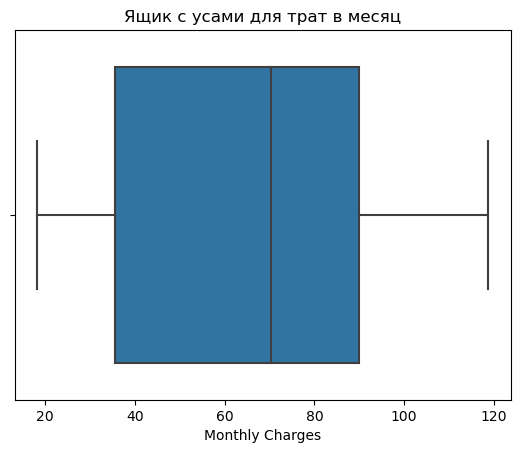

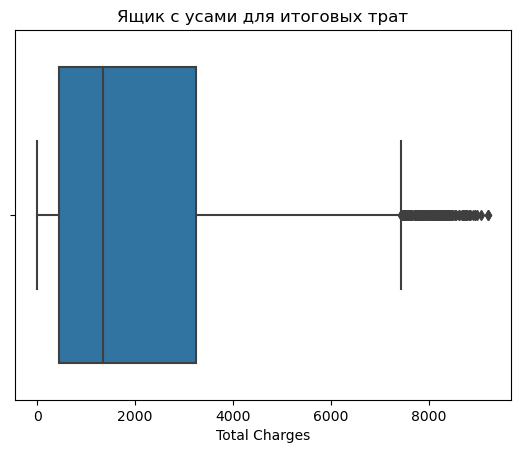

In [25]:
# Para los otros dos números, construyamos cajas con bigotes:
# Cajón de bigote para columna MonthlyCharges

sns.boxplot(data['MonthlyCharges'])
plt.xlabel('Monthly Charges')
plt.title('Ящик с усами для трат в месяц')
plt.show()

# Cajón con bigote para columna TotalCharges

sns.boxplot(data['TotalCharges'])
plt.xlabel('Total Charges')
plt.title('Ящик с усами для итоговых трат')
plt.show()

In [26]:
# Vemos que la mayoría de los clientes gastan de 35 a 89 al mes. No hay emisiones.
# De acuerdo con los costos totales del número de 450 a 3300. Hay emisiones por encima de 8000, pero estos son los pocos clientes, 
# que han estado usando el servicio desde el principio.

In [27]:
# Examinaremos todos los demás temas:
# Crear una función para histogramas:

def plot_histogram(data, column, xlabel='', ylabel='Количество', title=''):
    sns.countplot(data=data, x=column)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

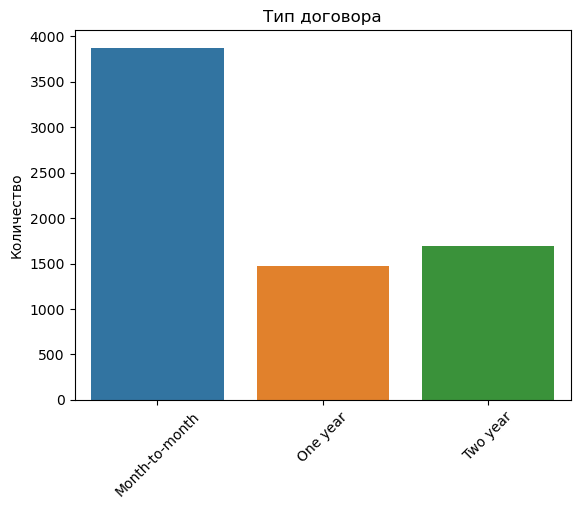

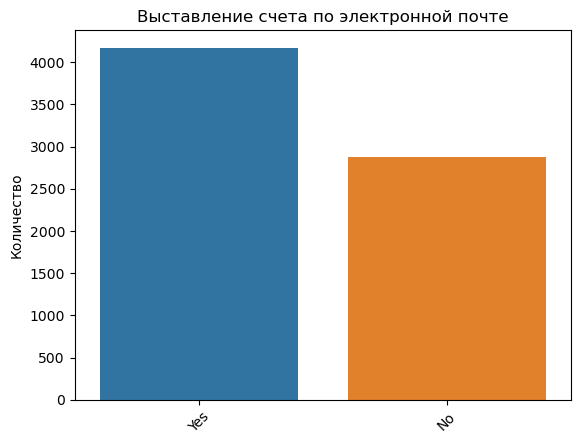

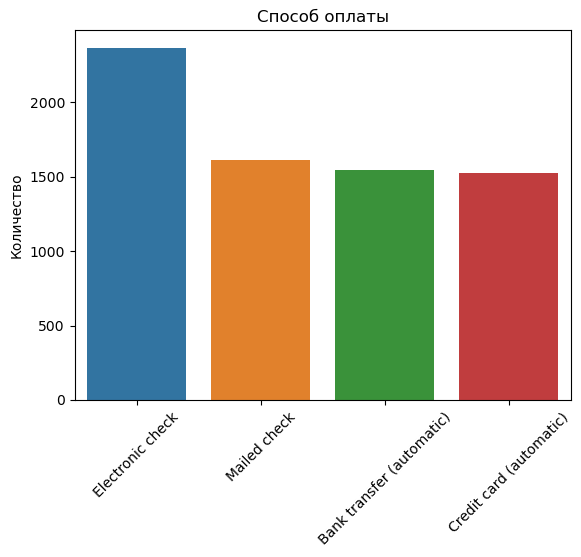

In [28]:
# Funciones de llamada para cada función Contract

plot_histogram(data=data, column='Type', title='Тип договора')
plot_histogram(data=data, column='PaperlessBilling', title='Выставление счета по электронной почте')
plot_histogram(data=data, column='PaymentMethod', title='Способ оплаты', xlabel='')

Vemos que entre los tipos de contrato predomina el pago mensual, la cuenta recibe un poco más por correo electrónico, y el método de pago más popular es un cheque electrónico, los otros tres se distribuyen aproximadamente por igual.

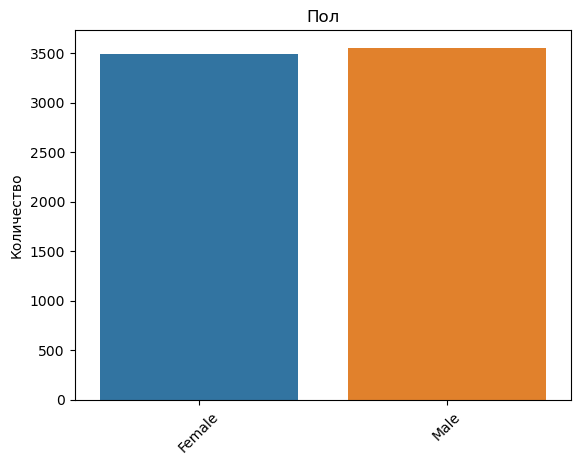

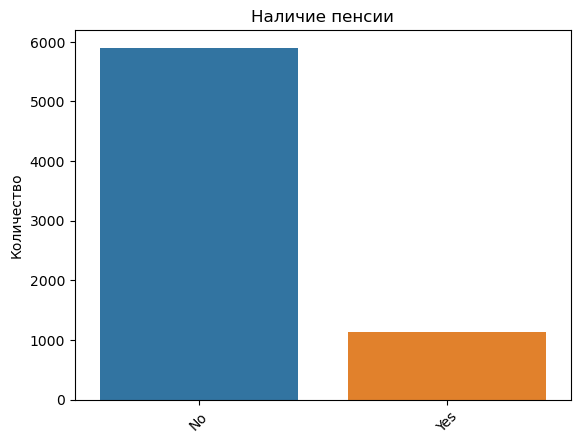

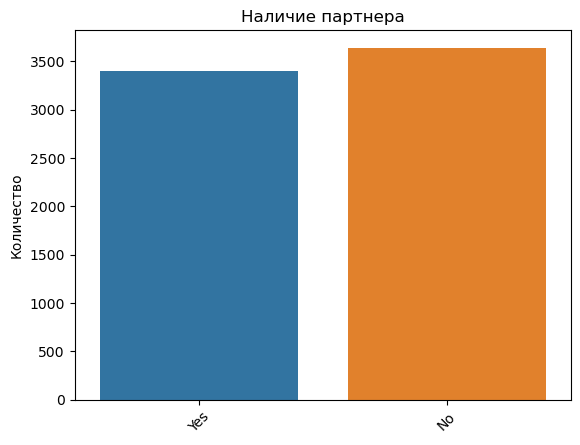

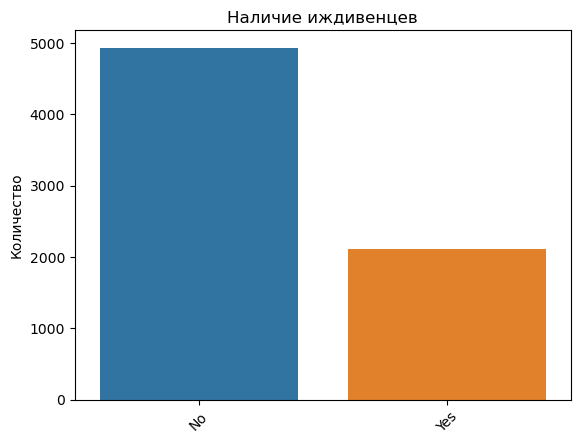

In [29]:
# Llamada de función para cada bloque de características personales
plot_histogram(data=data, column='gender', title='Пол')
plot_histogram(data=data, column='SeniorCitizen', title='Наличие пенсии')
plot_histogram(data=data, column='Partner', title='Наличие партнера')
plot_histogram(data=data, column='Dependents', title='Наличие иждивенцев')

Los clientes se dividen aproximadamente por igual por sexo y pareja.   
Jubilados - pequeña proporción (aproximadamente 1/7), también con aproximadamente 2/7 dependientes

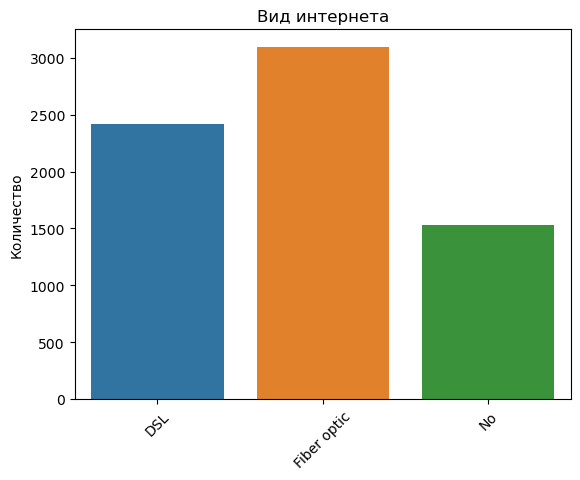

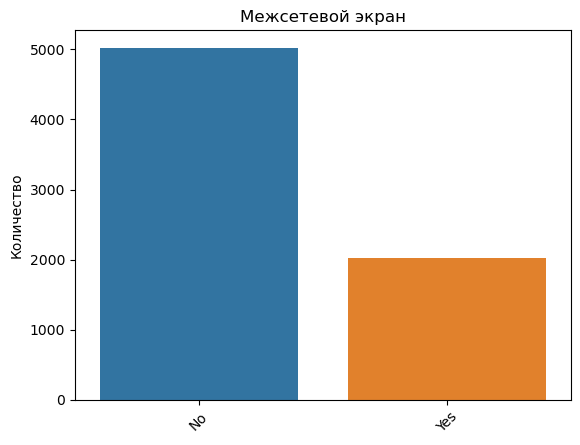

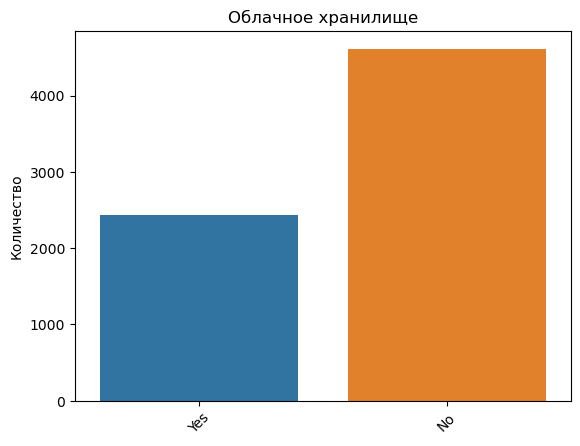

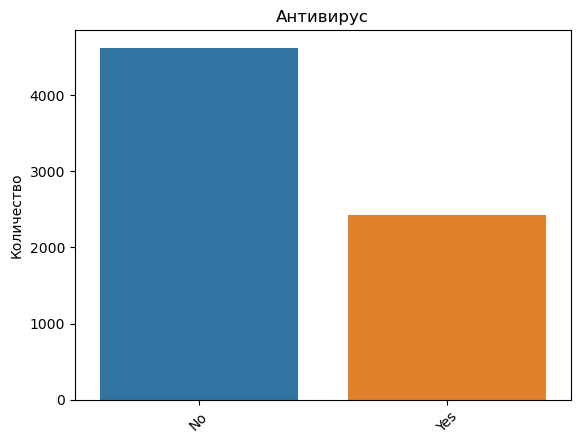

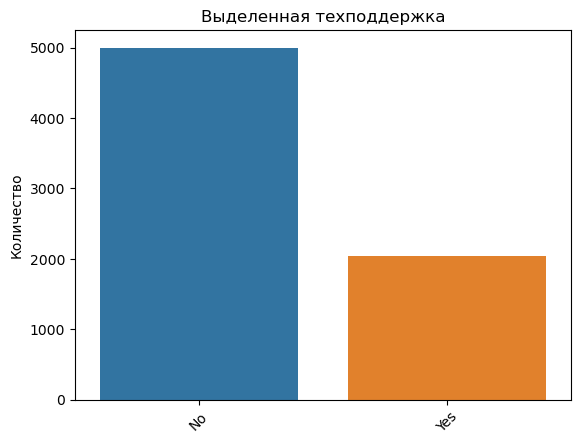

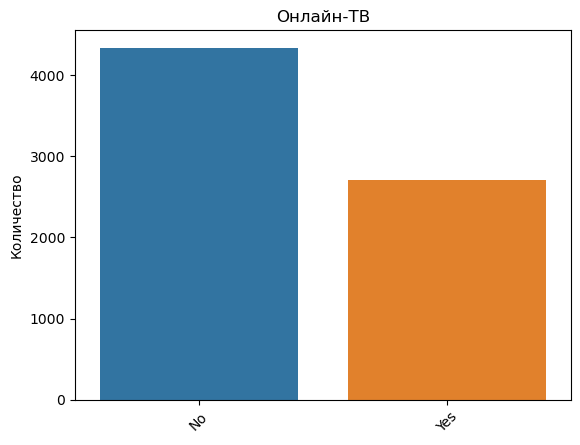

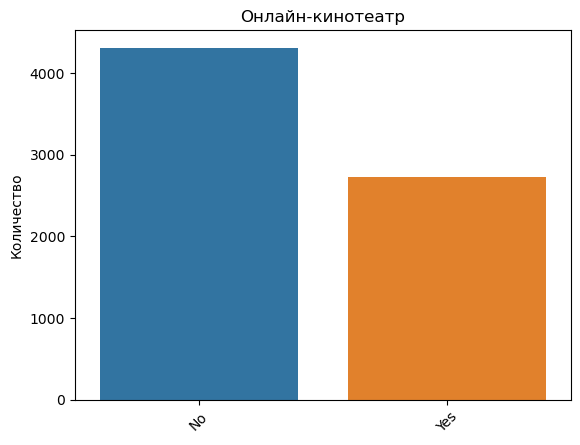

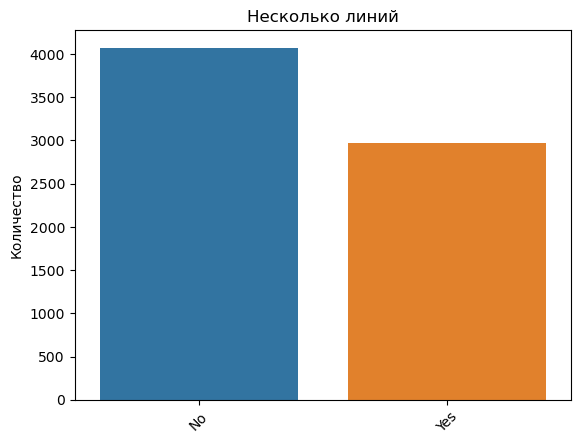

In [30]:
# Función de llamada para cada función de bloqueo de Internet y teléfono
plot_histogram(data=data, column='InternetService', title='Вид интернета')
plot_histogram(data=data, column='OnlineSecurity', title='Межсетевой экран')
plot_histogram(data=data, column='OnlineBackup', title='Облачное хранилище')
plot_histogram(data=data, column='DeviceProtection', title='Антивирус')
plot_histogram(data=data, column='TechSupport', title='Выделенная техподдержка')
plot_histogram(data=data, column='StreamingTV', title='Онлайн-ТВ')
plot_histogram(data=data, column='StreamingMovies', title='Онлайн-кинотеатр')
plot_histogram(data=data, column='MultipleLines', title='Несколько линий')

Vemos que en el uso principal de servicios adicionales no es muy activo.   
Entre los usuarios de Internet, la fibra óptica gana ligeramente. Para otros servicios, conectan a unos 2/7 clientes.

### Distribución de temas entre los difuntos y los restantes

In [31]:
# Para el estudio de los patrones entre los que se han ido y comparaciones con los que se han quedado, separemos dos datacets

gone_data = data[data.Gone == 1]
remaining_data = data[data.Gone != 1]

In [32]:
# Haga una función para histogramas comparativos:

def plot_histogram_comparison(data1, data2, labels, title):
    plt.hist([data1, data2], label=labels, density=True)
    plt.legend()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Соотношение')
    plt.show()

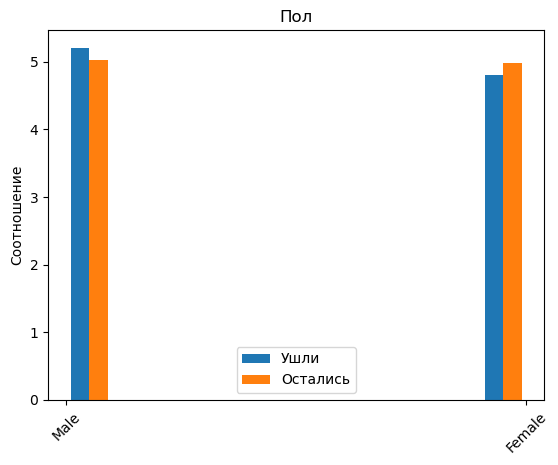

In [33]:
# Construir gráficos comparativos

plot_histogram_comparison(gone_data['gender'], remaining_data['gender'], ['Ушли', 'Остались'], 'Пол')

# Lo marcaré si encuentro un patrón. 
# No hay ningún patrón

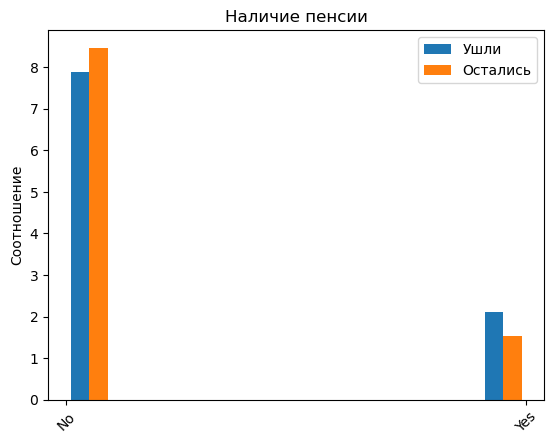

In [34]:
plot_histogram_comparison(gone_data['SeniorCitizen'], remaining_data['SeniorCitizen'], ['Ушли', 'Остались'], 'Наличие пенсии')

# Un poco más a menudo los jubilados salen

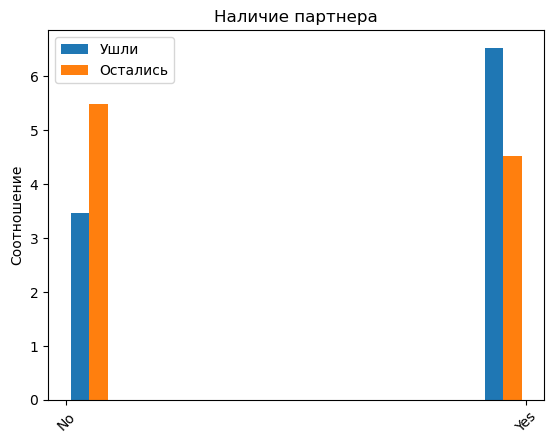

In [35]:
plot_histogram_comparison(gone_data['Partner'], remaining_data['Partner'], ['Ушли', 'Остались'], 'Наличие партнера')

# La mayoría de la gente se va en pares

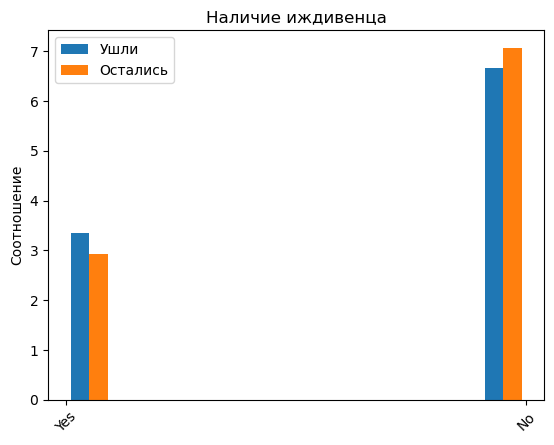

In [36]:
plot_histogram_comparison(gone_data['Dependents'], remaining_data['Dependents'], ['Ушли', 'Остались'], 'Наличие иждивенца')

# Tener un hijo no afecta el cuidado

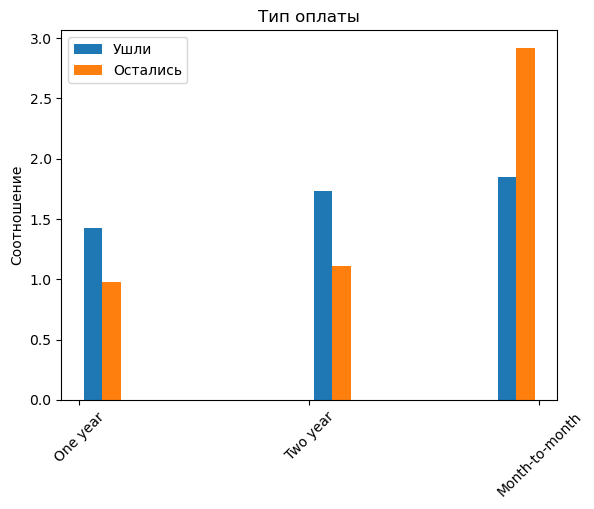

In [37]:
plot_histogram_comparison(gone_data['Type'], remaining_data['Type'], ['Ушли', 'Остались'], 'Тип оплаты')

# Los que tienen contratos de 1 y 2 años se van más a menudo. Los clientes con pago mensual permanecen.

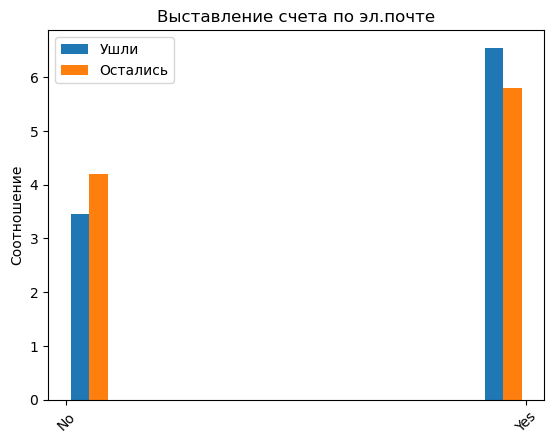

In [38]:
plot_histogram_comparison(gone_data['PaperlessBilling'], remaining_data['PaperlessBilling'], ['Ушли', 'Остались'], 'Выставление счета по эл.почте')

# Hay poca diferencia

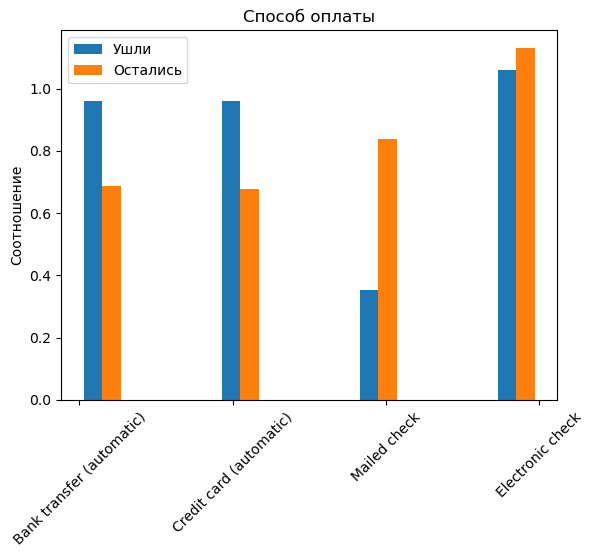

In [39]:
plot_histogram_comparison(gone_data['PaymentMethod'], remaining_data['PaymentMethod'], ['Ушли', 'Остались'], 'Способ оплаты')

# Un poco más a menudo los clientes se van con el pago a través del banco y la tarjeta de crédito. Los clientes con un cheque postal en su mayoría permanecen.

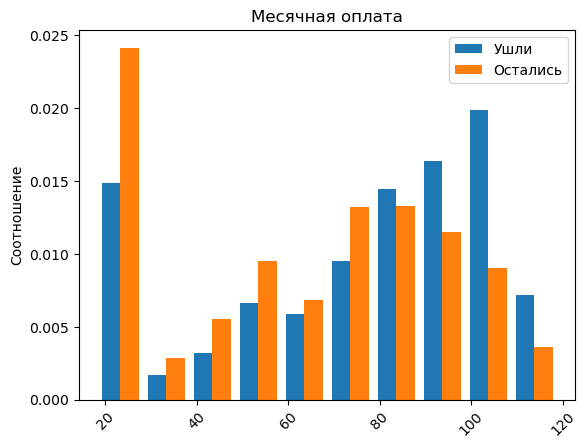

In [40]:
plot_histogram_comparison(gone_data['MonthlyCharges'], remaining_data['MonthlyCharges'], ['Ушли', 'Остались'], 'Месячная оплата')

# Aquí vemos que los que pagan por encima de 80 se van. Y la mayor diferencia son los que pagan 100.

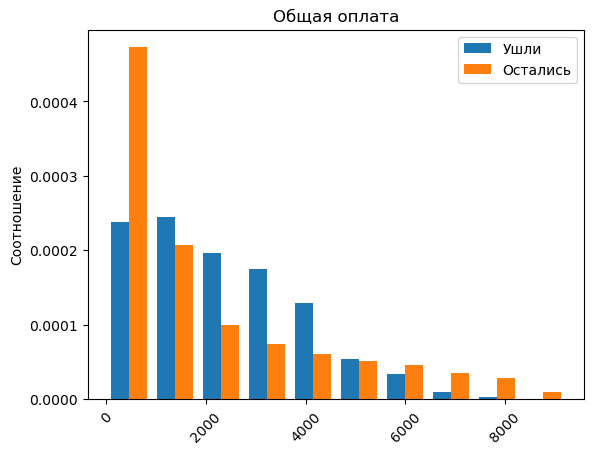

In [41]:
plot_histogram_comparison(gone_data['TotalCharges'], remaining_data['TotalCharges'], ['Ушли', 'Остались'], 'Общая оплата')

# Aquí vemos que los que pagaron incluso menos de 1000 no se van (nuevos clientes), los que ya han pagado más de 5000
# tampoco deja de fumar - estos ya son clientes leales. El principal riesgo entre 1000 - 5000.

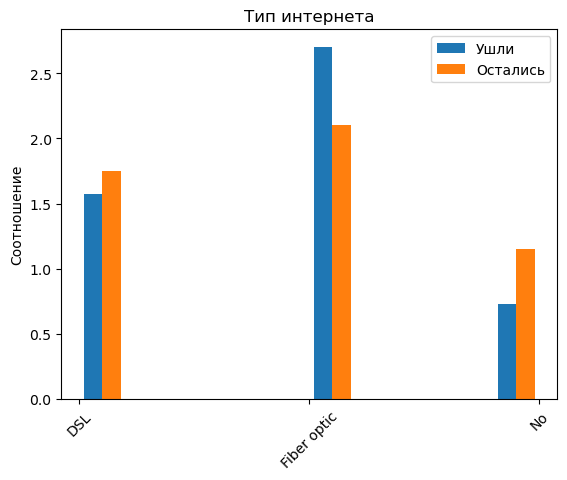

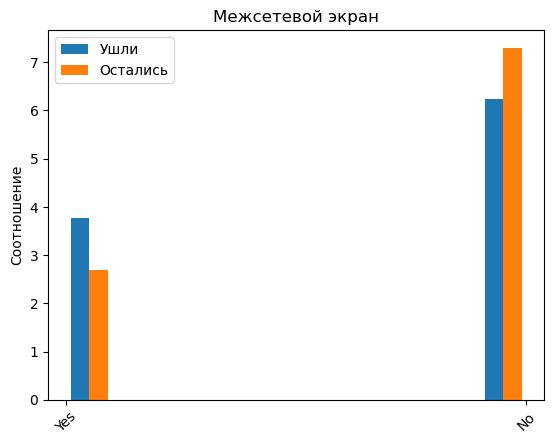

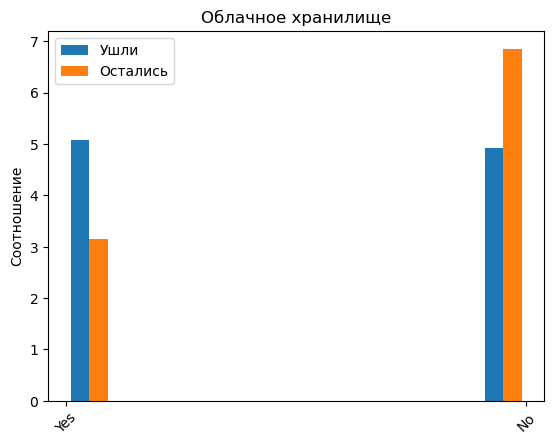

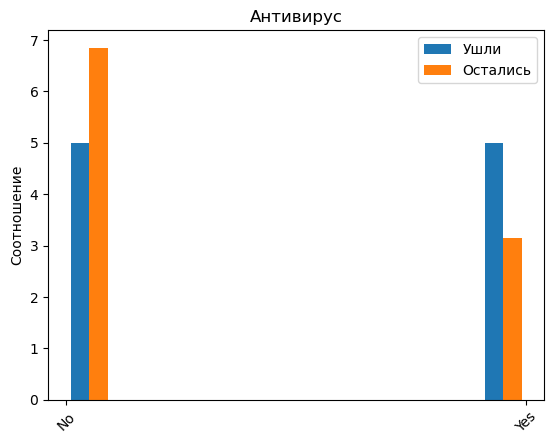

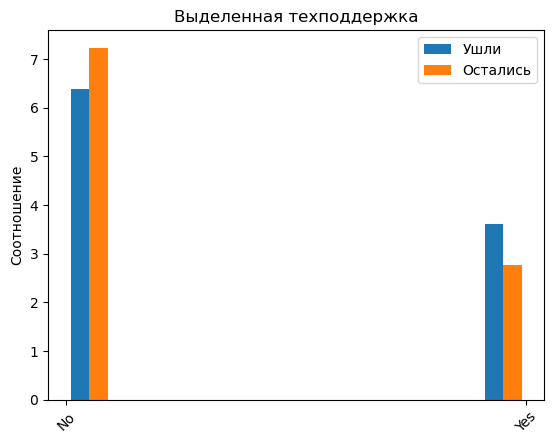

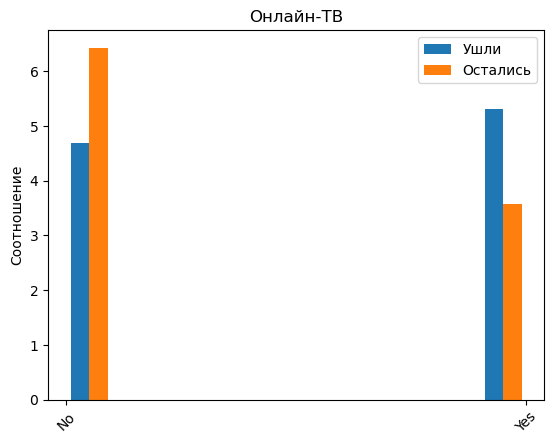

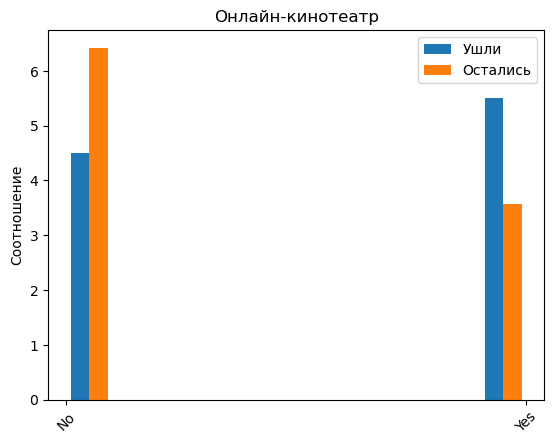

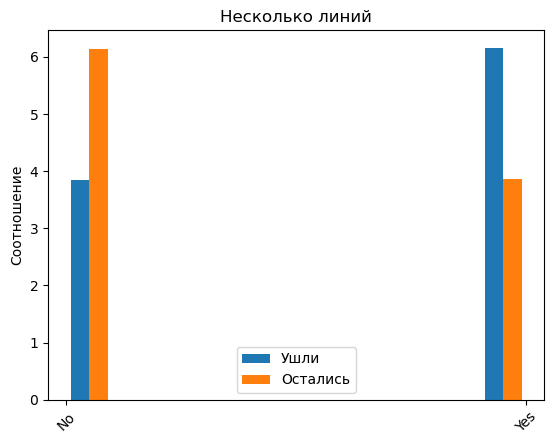

In [42]:
plot_histogram_comparison(gone_data['InternetService'], remaining_data['InternetService'], ['Ушли', 'Остались'], 'Тип интернета')

plot_histogram_comparison(gone_data['OnlineSecurity'], remaining_data['OnlineSecurity'], ['Ушли', 'Остались'], 'Межсетевой экран')

plot_histogram_comparison(gone_data['OnlineBackup'], remaining_data['OnlineBackup'], ['Ушли', 'Остались'], 'Облачное хранилище')

plot_histogram_comparison(gone_data['DeviceProtection'], remaining_data['DeviceProtection'], ['Ушли', 'Остались'], 'Антивирус')

plot_histogram_comparison(gone_data['TechSupport'], remaining_data['TechSupport'], ['Ушли', 'Остались'], 'Выделенная техподдержка')

plot_histogram_comparison(gone_data['StreamingTV'], remaining_data['StreamingTV'], ['Ушли', 'Остались'], 'Онлайн-ТВ')

plot_histogram_comparison(gone_data['StreamingMovies'], remaining_data['StreamingMovies'], ['Ушли', 'Остались'], 'Онлайн-кинотеатр')

plot_histogram_comparison(gone_data['MultipleLines'], remaining_data['MultipleLines'], ['Ушли', 'Остались'], 'Несколько линий')

La distribución del servicio se combinó en un solo bloque.  
La diferencia entre ellos parece insignificante, pero si lo considera, más a menudo se van: clientes con fibra óptica y firewall conectado, almacenamiento en la nube, antivirus, soporte dedicado, TV en línea, cine en línea, varias líneas. Ej. cualquiera de los servicios conectados aumenta el riesgo de que el cliente se vaya.

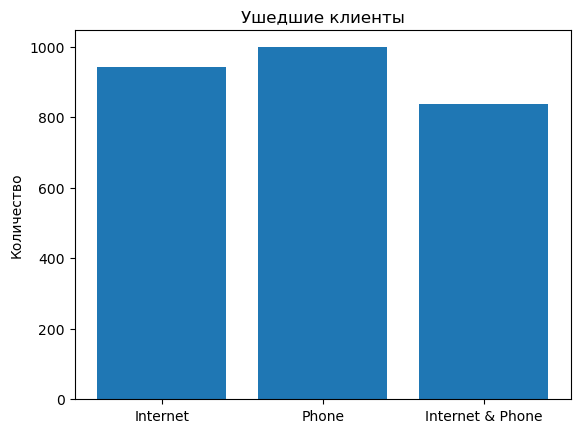

In [43]:
# Pensé en ello, y decidió agregar un histograma que compara a los clientes que se fueron por tipo de servicio.

def plot_histogram_gone(data, labels, title):
    plt.bar(labels, data)
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.show()

filtered_data = data[data['Gone'] == 1]
internet_yes_count = filtered_data[filtered_data['Internet'] == 'Yes'].shape[0]
phone_yes_count = filtered_data[filtered_data['Phone'] == 'Yes'].shape[0]
internet_phone_yes_count = filtered_data[(filtered_data['Internet'] == 'Yes') & (filtered_data['Phone'] == 'Yes')].shape[0]

plot_histogram_gone([internet_yes_count, phone_yes_count, internet_phone_yes_count],
                          ['Internet', 'Phone', 'Internet & Phone'], 'Ушедшие клиенты')

### Conclusiones preliminares

Vamos a recoger conclusiones preliminares antes de entrenar el modelo.  
- Combinamos cuatro datacets en uno basado en el ID del cliente correspondiente
- Tipos de datos cambiados (dos columnas conducían a fechas), una análoga a las otras al texto, una opuesta a numérica.
- Añadidas características de columna (tipo de cliente de Internet/ teléfono), columna con el número de meses, cuántos clientes en la empresa, y también añadió la columna de destino - los clientes que se han ido
- Histogramas y cajas construidas con bigotes para observar la distribución de características
- En el pago vimos que la mayoría de los clientes gastan de 35 a 89 al mes. En los gastos totales de 450 a 3300. Hay emisiones por encima de 8000, pero estos son clientes leales que han estado utilizando el servicio desde el principio.
- En el grupo de riesgos preliminares, que dejan más a menudo: pensionistas, personas en una pareja, los que concluyeron contratos anuales y de dos años, pagados a través del banco y la tarjeta de crédito. Para los pagos de grupos de riesgo, los que pagan más de 80 por mes, y para todo el plazo del cliente pagado de 1000 a 5000.
- También se constató que cualquiera de los servicios adicionales conectados son pocos, pero aumentan el riesgo de abandono del cliente.
- Hay un poco más de personas que utilizan los servicios telefónicos solo entre los clientes que se fueron.

### Entrenamiento y pasos de control del modelo

Los datos están listos para su análisis y están previstas las siguientes acciones:
    
1. Eliminar columnas que no necesitamos (p. ej., inicio y fin del contrato)
2. Dividir el conjunto de datos en muestras de entrenamiento y de ensayo en una proporción de 3 a 1
3. Codificar características categóricas con codificación en caliente
4. Seleccionar hiperparámetros (planificar con GridSearch)
5. Si hay un desequilibrio, realice el equilibrio (por ejemplo, con class_weight)
6. Aprenda y compare dos modelos sobre validación cruzada (plan RandomForestClassifier y CatBoost)
7. Elija el mejor modelo de validación cruzada
8. Compruebe el mejor modelo en la muestra de prueba
9. Visualizar resultados, construir gráfico ROC
10. Interpretar la precisión para el cliente

## Formación modelo

### Quitar características superfluas

In [44]:
# Antes de quitar las columnas que no necesitamos.
# Esta es la columna Fechas y la columna de Internet - porque el uso de Internet duplica 
# Columna del servicio de Internet (No - Internet no estaba conectado)
# Para no eliminar columnas sin trazas, guárdelas en una tabla separada

new_data = data[['BeginDate', 'EndDate', 'Internet']].copy()

# Eliminar columnas de la tabla de origen
data.drop(['BeginDate', 'EndDate', 'Internet'], axis=1, inplace=True)

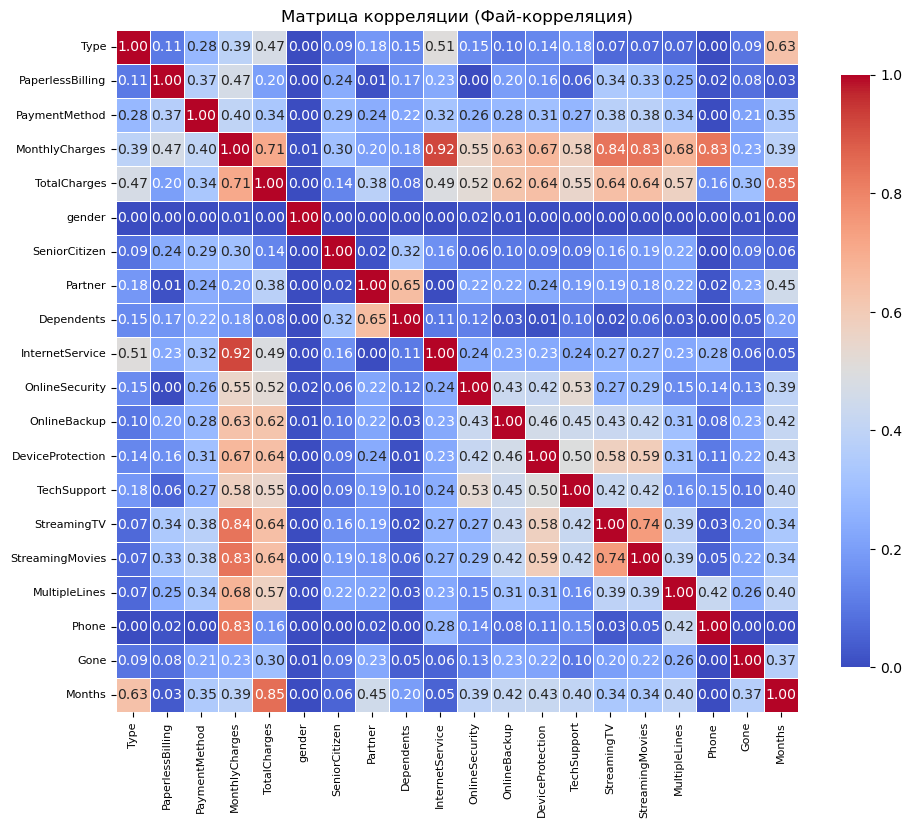

In [45]:
# Cree una matriz de correlación usando la herramienta phik para ver qué características aún se pueden eliminar.
# Eliminar rasgos numéricos 'MonthlyCharges', 'TotalCharges' y 'Meses'

interval_cols = ['MonthlyCharges', 'TotalCharges', 'Months']
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

# Crear mapa térmico de la matriz de correlación
plt.figure(figsize=(11, 11))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f", linewidths=0.5, cbar=True, cbar_kws={'shrink': 0.7})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Матрица корреляции (Фай-корреляция)')
plt.show()

In [46]:
# Eliminar las siguientes características también (la lista fue determinada por largos ensayos y errores hasta que se obtuvo el rocauc necesario)

new_data = new_data.assign(Phone=data['Phone'],
                           InternetService=data['InternetService'],
                           TotalCharges=data['TotalCharges'],
                           )

# Para eliminar columnas de la tabla de origen
data.drop(['Phone', 'InternetService', 'TotalCharges'], axis=1, inplace=True)

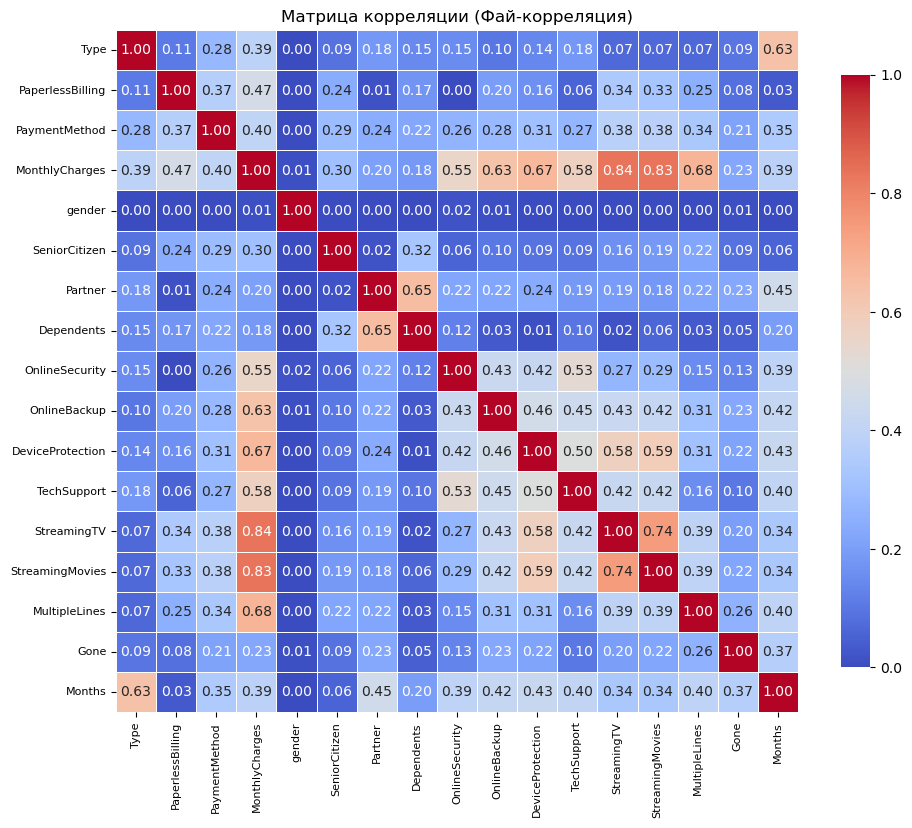

In [47]:
interval_cols = ['MonthlyCharges', 'Months']
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

# Crear mapa térmico de la matriz de correlación
plt.figure(figsize=(11, 11))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f", linewidths=0.5, cbar=True, cbar_kws={'shrink': 0.7})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Матрица корреляции (Фай-корреляция)')
plt.show()

### Muestreo

In [48]:
RANDOM_STATE = 60623

In [49]:
X = data.drop('Gone', axis=1)
y = data['Gone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print("Размер тренировочной выборки:", X_train.shape, y_train.shape)
print("Размер тестовой выборки:", X_test.shape, y_test.shape)

Размер тренировочной выборки: (5282, 16) (5282,)
Размер тестовой выборки: (1761, 16) (1761,)


In [50]:
# Compare el balance de clases en las muestras objetivo, debe ser aproximadamente el mismo para una evaluación más objetiva del modelo
print(y.mean())
print(y_train.mean())
print(y_test.mean())

0.15632542950447254
0.1563801590306702
0.15616127200454288


### CatBoost

In [51]:
%%time

# Dado que CatBoost en sí puede codificar características categóricas, vamos a empezar con él.
# Definición de características y variable de destino

exclude_features = ['MonthlyCharges', 'Months']
features = [feat for feat in X_train.columns if feat not in exclude_features]

model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=features, verbose=0, 
                               auto_class_weights='Balanced', eval_metric='AUC', early_stopping_rounds=10)

param_grid_cbc = {
    'learning_rate': [0.001, 0.01, 0.1, 1.0 ],
    'max_depth': range(2, 6),
    'n_estimators': range(1800, 2201, 100)
}

grid_search_cbc = GridSearchCV(estimator=model_cbc, param_grid=param_grid_cbc, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_cbc.fit(X_train, y_train)

best_model_cbc = grid_search_cbc.best_estimator_

print("Лучшие параметры: ", grid_search_cbc.best_params_)
print("Лучший ROC AUC: ", grid_search_cbc.best_score_)

Лучшие параметры:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1900}
Лучший ROC AUC:  0.8262104054082513
CPU times: user 10 s, sys: 4.48 s, total: 14.5 s
Wall time: 9min 28s


### Codificación de características para el modelo "de madera"

In [101]:
columns_to_exclude = ['MonthlyCharges', 'Months']

categorical_columns = [col for col in X_train.columns if col not in columns_to_exclude]

categorical_train = X_train[categorical_columns]
categorical_test = X_test[categorical_columns]

encoder = OrdinalEncoder()

encoded_train = encoder.fit_transform(categorical_train)
encoded_test = encoder.transform(categorical_test)

X_train_encoded = X_train.copy()
X_train_encoded[categorical_columns] = encoded_train

X_test_encoded = X_test.copy()
X_test_encoded[categorical_columns] = encoded_test

X_train_encoded.drop(columns=['MonthlyCharges', 'Months'], inplace=True)
X_test_encoded.drop(columns=['MonthlyCharges', 'Months'], inplace=True)

scaler = RobustScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[columns_to_exclude]), columns=columns_to_exclude, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[columns_to_exclude]), columns=columns_to_exclude, index=X_test.index)

X_train_processed = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_test_processed = pd.concat([X_test_encoded, X_test_scaled], axis=1)

print(X_train_processed)
print(X_test_processed)

            Type  PaperlessBilling  PaymentMethod  gender  SeniorCitizen  \
customerID                                                                 
2788-CJQAQ   1.0               0.0            3.0     1.0            0.0   
0212-ISBBF   0.0               1.0            2.0     0.0            0.0   
4146-SVFUD   0.0               0.0            3.0     1.0            0.0   
6897-UUBNU   0.0               0.0            3.0     1.0            0.0   
1699-UOTXU   2.0               0.0            2.0     1.0            0.0   
...          ...               ...            ...     ...            ...   
5602-BVFMK   1.0               0.0            3.0     0.0            0.0   
3058-WQDRE   0.0               1.0            0.0     1.0            0.0   
3786-WOVKF   1.0               1.0            0.0     0.0            1.0   
6233-HXJMX   0.0               1.0            1.0     0.0            0.0   
3519-ZKXGG   0.0               1.0            2.0     0.0            0.0   

           

### RandomForestClassifier

In [102]:
%%time

model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid_rfc = {
    'n_estimators': range(50, 100, 2),
    'max_depth': range(2, 20, 2),
    'max_features': range(1, 15),
}

grid_search_rfc = GridSearchCV(model_rfc, param_grid_rfc, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_rfc.fit(X_train_processed, y_train)

best_model_rfc = grid_search_rfc.best_estimator_

y_pred_proba_train = best_model_rfc.predict_proba(X_train_processed)

roc_auc_train = roc_auc_score(y_train, y_pred_proba_train[:, 1])
print("ROC AUC на тренировочной выборке: {:.2f}".format(roc_auc_train))

print("Лучшие гиперпараметры: ", grid_search_rfc.best_params_)

ROC AUC на тренировочной выборке: 0.93
Лучшие гиперпараметры:  {'max_depth': 8, 'max_features': 8, 'n_estimators': 84}
CPU times: user 1min 35s, sys: 10.4 s, total: 1min 45s
Wall time: 12min 12s


### Las mejores pruebas de modelos

El RandomForestClassifier ha demostrado un mejor rendimiento, vamos a probarlo.

In [103]:
y_pred_proba_test = best_model_rfc.predict_proba(X_test_processed)

roc_auc_test = roc_auc_score(y_test, y_pred_proba_test[:, 1])
print("ROC AUC на тестовой выборке: {:.2f}".format(roc_auc_test))

ROC AUC на тестовой выборке: 0.86


¡El umbral necesario de 0,85 se supera! Construyamos una curva ROC.

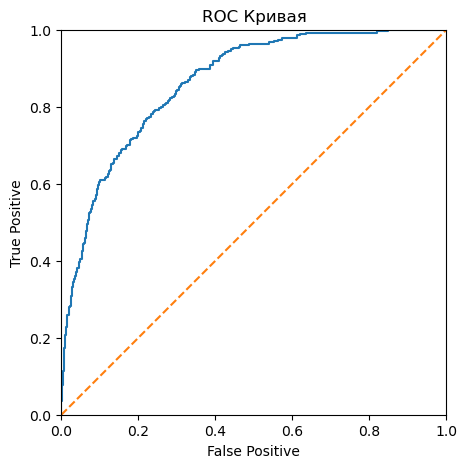

In [104]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:, 1])
plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Кривая')
plt.show()

### Análisis de precisión

In [105]:
y_pred_test = best_model_rfc.predict(X_test_processed)

accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy на тестовой выборке: {:.2f}".format(accuracy_test))

Accuracy на тестовой выборке: 0.87


Vemos que el modelo clasificó correctamente el 87% de los ejemplos en la muestra de prueba.

### Matrix error

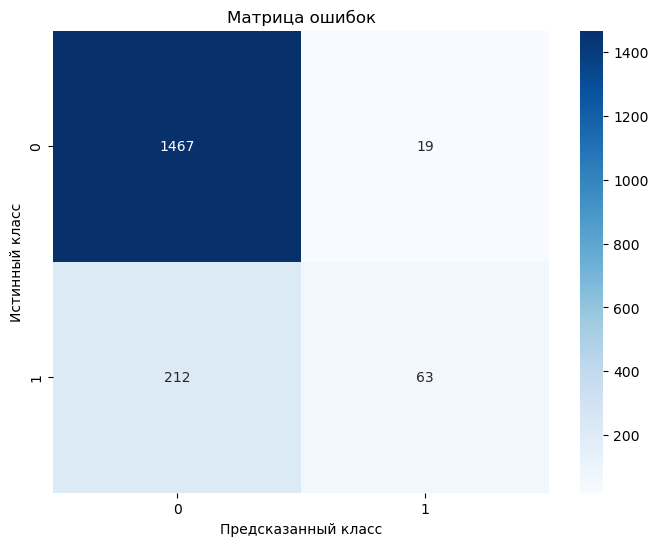

In [106]:
y_pred_test = best_model_rfc.predict(X_test_processed)

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

En la matriz de errores, se puede observar que el modelo predice correctamente los casos negativos (True Negative), lo que significa que clasifica correctamente los clientes que no salen.

### Análisis de importancia de características

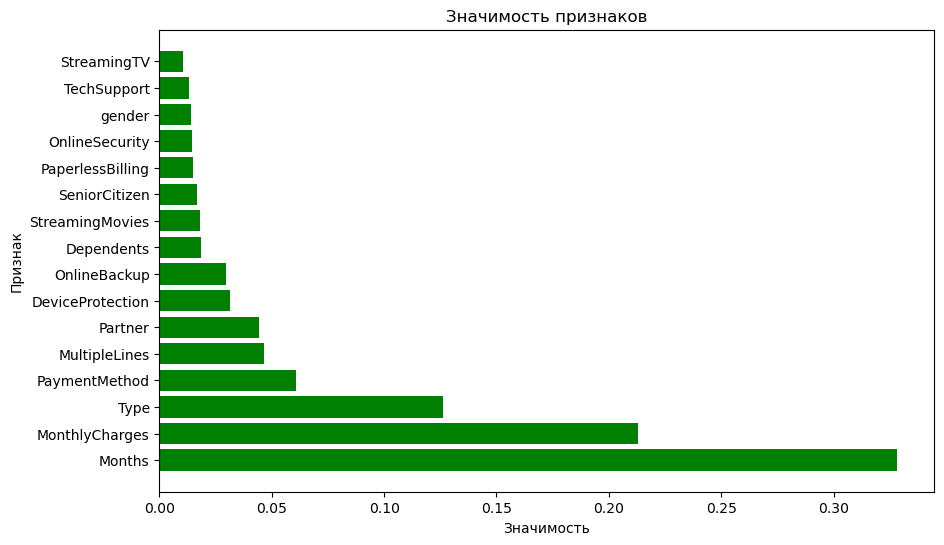

In [108]:
X_test_scaled_df = pd.DataFrame(X_test_processed, columns=X_test_processed.columns)

importances = grid_search_rfc.best_estimator_.feature_importances_
importances_df = pd.DataFrame(importances, index=X_test_scaled_df.columns, columns=['importance'])
importances_df = importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances_df.index, importances_df['importance'], color='green')
plt.xlabel('Значимость')
plt.ylabel('Признак')
plt.title('Значимость признаков')
plt.show()

Vemos que el signo más importante por el que los clientes se van: el número de meses de uso de los servicios. Aproximadamente la mitad menos: el costo del pago mensual y el tipo de contrato (mensual o 1/2 años). El resto de la evidencia en comparación no es tan importante.

### Informe final

Qué elementos del plan se aplicaron y cuáles no. ¿Por qué?  
Echemos un vistazo al plan original.  
✅ Eliminado las columnas que no necesitábamos - al final 6, 2 de los cuales fueron creados ellos mismos  
✅ Dividió el conjunto de datos en muestras de entrenamiento y pruebas en la proporción de 3 a 1  
✅ Funciones categóricas codificadas con One-Hot Encoding OrdinalEncoder y solo para el modelo RFC  
✅ Hiperparámetros seleccionados con GridSearch para ambos modelos  
✅ Equilibrio usado con peso de clase  
✅ Aprenda y compare dos modelos en validación cruzada (RandomForestClassifier y CatBoost)  
✅ Eligió el mejor modelo de validación cruzada  
✅ Probado el mejor modelo en la muestra de prueba  
✅ Resultados visualizados, gráfico ROC construido y matriz de errores  
✅ Mayor precisión para el cliente
  
¿Qué dificultades han surgido y cómo las han superado?  
La principal dificultad fue encontrar hiperparámetros para lograr la métrica roc-auc necesaria. En los datos primarios, Catbus mostró 0.83 en el trígono, y Randomles mostró 0.96 en el trígono, pero 0.81 en la prueba. Durante los experimentos, pasos como agregar equilibrio, agregar estratificación al muestreo, revisar la lista de temas para aprender, extender la cuadrícula de hiperparámetros, agregar estados aleatorios donde haya accidentes. Como resultado, mediante la revisión de la lista de características y la ampliación de la cuadrícula de hiperparámetros (basado en los mejores clasificados) fue posible lograr la métrica necesaria en uno de los modelos.
  
¿Cuáles son los pasos clave para resolver el problema que usted destacó?
Era importante combinar las tablas correctamente, procesar los datos y rellenar los espacios en blanco. A continuación, el elemento más importante - es analizar las señales y deshacerse de la basura. Después de ya empezar a entrenar modelos. Aquí es importante prestar atención a la selección de hiperparámetros y extender las cuadrículas si los mejores están en el borde.  
  
¿Qué características se utilizaron para entrenar el modelo y qué tratamiento previo de estas características se realizó?
Todo original excepto 'BeginDate', 'EndDate', 'InternetService', 'TotalCharges' + agregó 'Meses' - el número de meses que un cliente ha utilizado los servicios de la compañía. De atributos guardados de 'SeniorCitizen' hemos traducido al texto (Sí/ No), así como atascado No pasa por todas partes.
  
¿Cuál es su modelo final, cuáles son sus hiperparámetros y cuál es su calidad?  
Como resultado, el RandomForestClassifier ganó. Mostró roc-auc 0.91 en la muestra de entrenamiento y 0.86 en la muestra de prueba. Precisión en este modelo 0.87. Asesoramos a su cliente 👍